## **金融計算HW2**
##### 109072216 蔡曉榛

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data_normal = pd.read_csv('drive/MyDrive/data_normal.csv',index_col=0)
data_normal = data_normal.squeeze()
data_abnormal = pd.read_csv('drive/MyDrive/data_abnormal.csv',index_col=0)
data_abnormal = data_abnormal.squeeze()

In [8]:
data_normal

created_at                               2022-11-18T00:00:31.397Z
spot                                                      1199.07
put_amounts     [111.0, 579.0, 603.0, 450.0, 175.0, 58.0, 51.0...
put_ivs         [182.255, 162.965, 144.395, 126.52, 118.095, 1...
strikes         [600, 700, 800, 900, 950, 1000, 1050, 1100, 11...
expired_date                             2022-12-02T08:00:00.000Z
Name: 0, dtype: object

In [9]:
data_abnormal

created_at                               2022-11-23T18:30:11.690Z
spot                                                      1160.42
put_amounts     [36.0, 236.0, 311.0, 74.0, 445.0, 686.0, 309.0...
put_ivs         [184.0, 150.275, 141.125, 131.975, 123.33, 115...
strikes         [600, 700, 750, 800, 850, 900, 950, 1000, 1050...
expired_date                             2022-12-02T08:00:00.000Z
Name: 277, dtype: object

## **轉成GPU**

In [20]:
import torch
import time

In [21]:
torch.cuda.is_available()

True

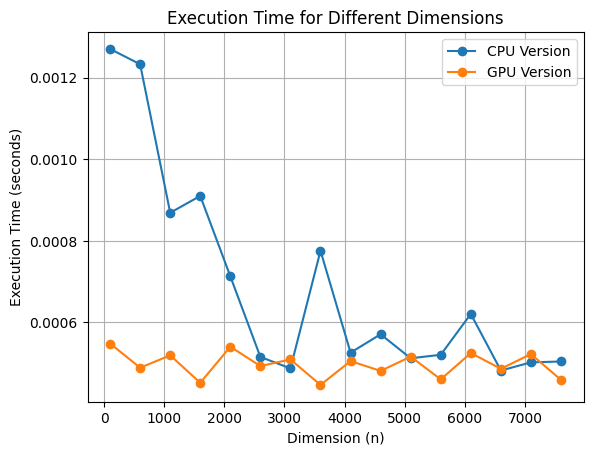

The mean-squared error is 16.820627212524414

The coefficient of the polynomial is (0.00014566289610229433, -0.42348748445510864, 386.5702209472656)
The weighted mean-squared error is 0.4346520006656647



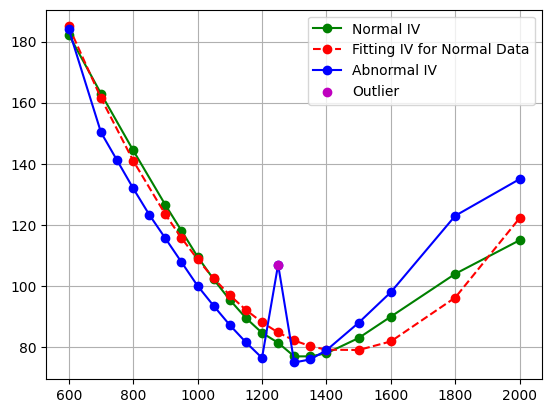

In [24]:
cpu_device = torch.device("cpu")       # cpu device
gpu_device = torch.device("cuda:0")   # gpu device



n_values = list(range(100, 8000,500))  # 不同的維度
results_cpu = []
results_gpu = []

def least_squares(device):
  device = device
  a = torch.tensor(eval(data_normal['strikes'])).unsqueeze(dim=1)
  A = torch.cat((torch.square(a),a,torch.ones(len(a)).unsqueeze(dim=-1)),-1)
  b = torch.tensor(eval(data_normal['put_ivs'])).unsqueeze(dim=1)
  A_T = torch.t(A)
  # (A_T*A)^-1*A_T*b
  X = torch.linalg.inv(torch.mm(A_T,A)).mm(A_T).mm(b)
  Y = X[0] * a**2 + X[1] * a + X[2]
  mse = torch.mean((b - Y) ** 2)
  amount = torch.tensor(eval(data_normal['put_amounts']))
  weights = amount/amount.sum()
  weighted_mse = torch.mean(weights * (b.squeeze() - Y.squeeze())**2)
  return X,Y,a,b,mse,weighted_mse

for n in n_values:
    start_time = time.time()
    X,Y,a,b,mse,weighted_mse = least_squares(device=cpu_device)
    execution_time = time.time() - start_time
    results_cpu.append(execution_time)

for n in n_values:
    start_time = time.time()
    X,Y,a,b,mse,weighted_mse = least_squares(device=gpu_device)
    execution_time = time.time() - start_time
    results_gpu.append(execution_time)

# 繪制花費秒數結果
plt.plot(n_values, results_cpu, marker='o', label='CPU Version')
plt.plot(n_values, results_gpu, marker='o',label = 'GPU Version')
plt.xlabel('Dimension (n)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time for Different Dimensions')
plt.legend()
plt.grid(True)
plt.show()



abnormal_put_amounts=torch.tensor(eval(data_abnormal['put_amounts']))
abnormal_put_ivs=torch.tensor(eval(data_abnormal['put_ivs']))
abnormal_strikes=torch.tensor(eval(data_abnormal['strikes']))
outlier_value = 107.025
outlier_index = np.argwhere(abnormal_put_ivs == outlier_value)
print(f'The mean-squared error is {mse}\n')
print(f'The coefficient of the polynomial is {X[0].item(),X[1].item(),X[2].item()}')
print(f'The weighted mean-squared error is {weighted_mse}\n')
plt.plot(a,b,'g-o',label='Normal IV')
plt.plot(a,Y,'r--o',label='Fitting IV for Normal Data')
plt.plot(abnormal_strikes, abnormal_put_ivs, 'b-o', label='Abnormal IV')
plt.scatter(abnormal_strikes[outlier_index], abnormal_put_ivs[outlier_index], color='m', label='Outlier', zorder=5)
plt.legend()
plt.grid()
plt.show()
